In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor,IsolationForest
from sklearn.metrics import mean_absolute_error,r2_score
from imblearn.over_sampling import SMOTE 
import warnings
warnings.filterwarnings('ignore')

# **EDA**

#### **Answer1**

In [2]:
#load the data

df = pd.read_csv('green_tripdata_2016-12.csv')

In [3]:
df.head()

VendorID lpep_pickup_datetime  \
2 2016-12-01 00:00:54  2016-12-01 00:06:54                    N   
  2016-12-01 00:52:41  2016-12-01 00:54:51                    N   
  2016-12-01 00:10:39  2016-12-01 00:14:47                    N   
  2016-12-01 00:12:16  2016-12-01 00:15:31                    N   
  2016-12-01 00:29:22  2016-12-01 00:39:51                    N   

                       lpep_dropoff_datetime  store_and_fwd_flag  RatecodeID  \
2 2016-12-01 00:00:54                      1                  92         192   
  2016-12-01 00:52:41                      1                  92         171   
  2016-12-01 00:10:39                      1                  75         238   
  2016-12-01 00:12:16                      1                 166         151   
  2016-12-01 00:29:22                      1                 166          42   

                       PULocationID  DOLocationID  passenger_count  \
2 2016-12-01 00:00:54             1          1.29              6.5   
  2016-12-01 00:52:41             1          0.64              4.0   
  2016-12-01 00:10:39             2          0.89              5.5   
  2016-12-01 00:12:16             1          0.66              4.5   
  2016-12-01 00:29:22             1          2.15              9.5   

                       trip_distance  fare_amount  extra  mta_tax  tip_amount  \
2 2016-12-01 00:00:54            0.5          0.5   0.00      0.0         NaN   
  2016-12-01 00:52:41            0.5          0.5   1.06      0.0         NaN   
  2016-12-01 00:10:39            0.5          0.5   1.70      0.0         NaN   
  2016-12-01 00:12:16            0.5          0.5   1.74      0.0         NaN   
  2016-12-01 00:29:22            0.5          0.5   2.16      0.0         NaN   

                       tolls_amount  ehail_fee  improvement_surcharge  \
2 2016-12-01 00:00:54           0.3       7.80                      2   
  2016-12-01 00:52:41           0.3       6.36                      1   
  2016-12-01 00:10:39           0.3       8.50                      1   
  2016-12-01 00:12:16           0.3       7.54                      1   
  2016-12-01 00:29:22           0.3      12.96                      1   

                       total_amount  payment_type  trip_type  
2 2016-12-01 00:00:54             1           NaN        NaN  
  2016-12-01 00:52:41             1           NaN        NaN  
  2016-12-01 00:10:39             1           NaN        NaN  
  2016-12-01 00:12:16             1           NaN        NaN  
  2016-12-01 00:29:22             1           NaN        NaN

<div class='alert alert-danger'>We can see that all the columns are shifted by 2 towards left. On openning the data on notepad I found that this is due to presence of 2 empty columns at the end. Therefore we need to make sure that correct column name corresponds to correct column. We need to fix this in order to proceed ahead

In [4]:
columns = df.columns

df_new = pd.read_csv('green_tripdata_2016-12.csv',header=None,usecols=range(19),skiprows=1)

df_new.columns = df.columns

In [5]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224158 entries, 0 to 1224157
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   VendorID               1224158 non-null  int64  
 1   lpep_pickup_datetime   1224158 non-null  object 
 2   lpep_dropoff_datetime  1224158 non-null  object 
 3   store_and_fwd_flag     1224158 non-null  object 
 4   RatecodeID             1224158 non-null  int64  
 5   PULocationID           1224158 non-null  int64  
 6   DOLocationID           1224158 non-null  int64  
 7   passenger_count        1224158 non-null  int64  
 8   trip_distance          1224158 non-null  float64
 9   fare_amount            1224158 non-null  float64
 10  extra                  1224158 non-null  float64
 11  mta_tax                1224158 non-null  float64
 12  tip_amount             1224158 non-null  float64
 13  tolls_amount           1224158 non-null  float64
 14  ehail_fee         

In [6]:
# Converting lpep_pickup_datetime and lpep_dropoff_datetime columns to date time format

df_new['lpep_pickup_datetime'] = pd.to_datetime(df_new['lpep_pickup_datetime'])
df_new['lpep_dropoff_datetime'] = pd.to_datetime(df_new['lpep_dropoff_datetime'])

In [7]:
# function to plot heatmap of correlation matrix
def cor_heatmap(df,title):
    
    plt.figure(figsize=(8,6))
    corr = df.corr()
    plt.title(title,fontsize=20)
    sns.heatmap(corr, 
              xticklabels=corr.columns,
              yticklabels=corr.columns)
    plt.show()

In [8]:
# function to plot histogram
def plot_hist(data,bins,title,xlabel,ylabel):
    fig, ax = plt.subplots()
    data.hist(bins = range(bins),align='mid',edgecolor = "black",linewidth=1)
    ax.set_title(title,fontsize=20)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(bins))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    plt.show()

#### Numerical features statistics -

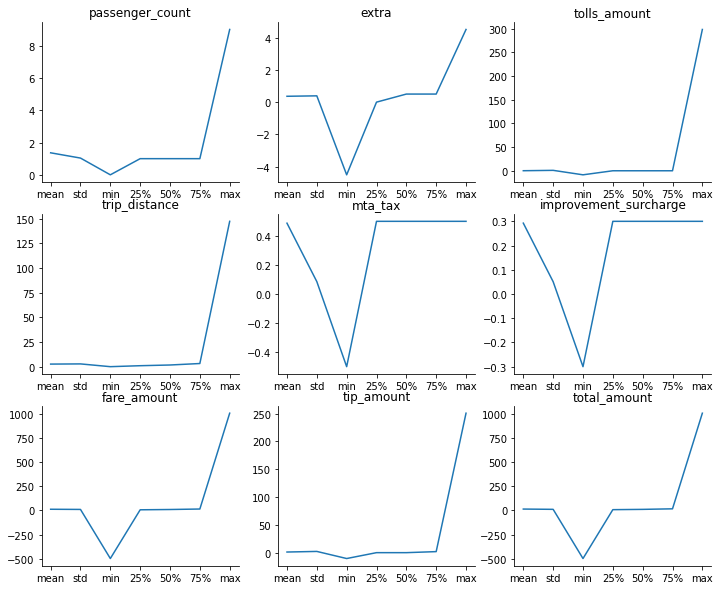

In [9]:
 
def feat_stat(df):
    fig, axes = plt.subplots(3,3,figsize=[12,10])

    num_col = ['passenger_count','trip_distance','fare_amount','extra','mta_tax','tip_amount',
               'tolls_amount','improvement_surcharge','total_amount']
    describe_df_new = df.describe()
    describe_df_new.reset_index(inplace=True)

    describe_df_new = describe_df_new[describe_df_new['index'] != 'count']
    index = ['mean','std','min','25%','50%','75%','max']

    describe_df_new.index = index
    for i in range(3):
        for j in range(3):
            axes[i,j].plot(describe_df_new[num_col[i+j*3]])
            axes[i,j].set_title(num_col[i+j*3])
            axes[i,j].spines['right'].set_visible(False)
            axes[i,j].spines['top'].set_visible(False)

feat_stat(df_new)

#### Data Range - 

In [10]:
print('Minimum pickup date: ' + str(min(df_new['lpep_pickup_datetime']))+
      '\nMinimum dropoff date: '+str(min(df_new['lpep_dropoff_datetime'])))

Minimum pickup date: 2016-12-01 00:00:00
Minimum dropoff date: 2016-12-01 00:00:00


In [11]:
print('Maximum pickup date: ' + str(max(df_new['lpep_pickup_datetime']))+
      '\nMaximum dropoff date: '+str(max(df_new['lpep_dropoff_datetime'])))

Maximum pickup date: 2016-12-31 23:59:59
Maximum dropoff date: 2017-01-01 23:28:49


#### Unique Vendor -

In [12]:
print('Unique Vendors: '+str(df_new['VendorID'].unique()))

Unique Vendors: [2 1]


#### Correlation - 

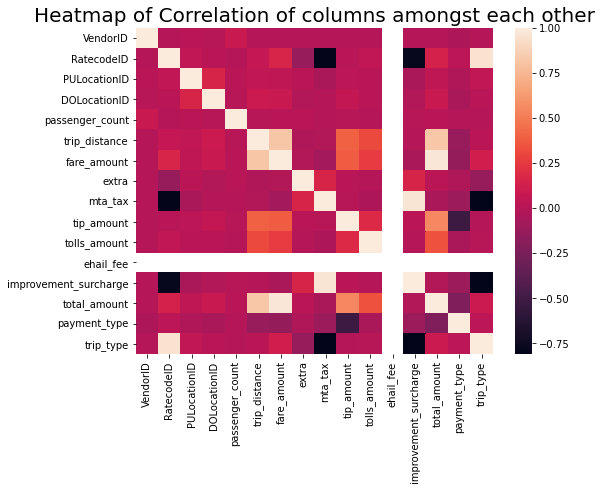

In [13]:
cor_heatmap(df_new,title = 'Heatmap of Correlation of columns amongst each other')

#### Tip distribution

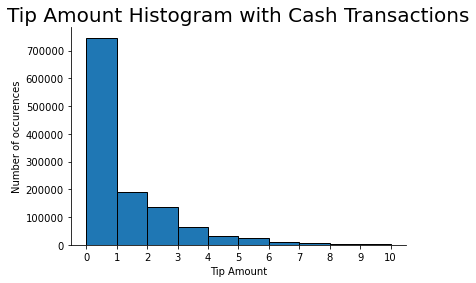

In [14]:
plot_hist(df_new['tip_amount'],11,title='Tip Amount Histogram with Cash Transactions',
          xlabel = 'Tip Amount',ylabel='Number of occurences')

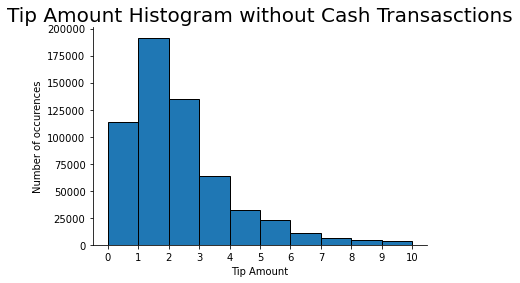

In [15]:
plot_hist(df_new[df_new['payment_type']!=2]['tip_amount'],11,title='Tip Amount Histogram without Cash Transasctions',
          xlabel = 'Tip Amount',ylabel='Number of occurences')

<div class="alert alert-block alert-success">
On performing above analysis following can be said about the data:

- Details for each column is published by Taxi and Limousine Commission and can be found at https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf
- Data contains records of taxi trip from 2016-12-01 to 2017-01-01
- There are some outliers in the data which either has exceptionally large, negative values or zero values. For example: negative tip amount, 0 passenger count, 147 mile trip distance, etc.
- Data is collected from only 2 vendors
- There exists high correlation amongst few columns. For example between trip_distance and fare_amount
- The column ehail_fee doesnot contains any data
- As per the link shared in point one, Tip Amount is automatically populated for credit card tips. Cash tips are not included. As a result, Tip Amount Histogram seems dominated by zero tips when cash transaction is also considered. Without considering cash transaction we can see that 1 dollar tip is maximum 
    
New York Green Taxi's data is not completely clean. There are some issues with the data that are stated above. To draw insights from the data, we need to resolve these issues

In [16]:
# removing outliers

df_new = df_new[(df_new['passenger_count'] > 0) & (df_new['trip_distance'] > 0)
                & (df_new['fare_amount'] > 0) & (df_new['mta_tax'] >= 0)
                & (df_new['tip_amount'] >= 0) & (df_new['tolls_amount'] >= 0) 
                & (df_new['improvement_surcharge'] >= 0) & (df_new['total_amount'] > 0)]

# restricting trip distance between 0.1 mile and 95 percentile 

df_new = df_new[(df_new['trip_distance'] < df_new['trip_distance'].quantile(.95))&(df_new['trip_distance'] > 0.1)]

In [17]:
# dropping ehail_fee column

df_new = df_new.drop(['ehail_fee'],axis=1)

#### Answer 2

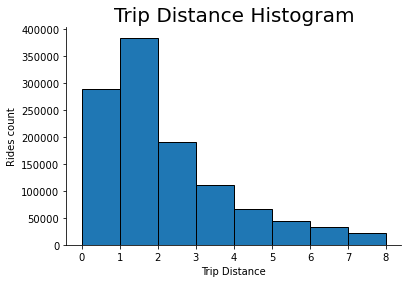

In [18]:
plot_hist(df_new['trip_distance'],9,title='Trip Distance Histogram',
          xlabel = 'Trip Distance',ylabel='Rides count')

<div class="alert alert-block alert-success">
<strong>Insights</strong> - Most of the trips were for short distances and got completed within 4 miles

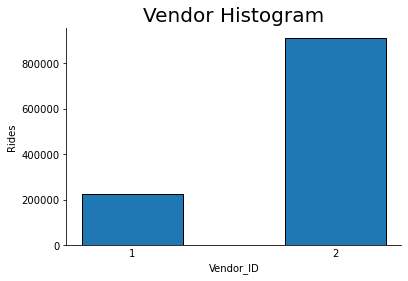

In [19]:

fig, ax = plt.subplots()
df_new['VendorID'].hist(bins=np.arange(0.75,2.5,0.5),align='mid',edgecolor = "black",linewidth=1)

ax.set_xticklabels(['','',1,'','','','',2])
ax.set_xlabel('')
ax.tick_params(axis='x',length=0)


ax.set_xlabel('Vendor_ID')
ax.set_ylabel('Rides')
ax.set_title('Vendor Histogram',fontsize = 20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

plt.show()

<div class="alert alert-block alert-success">
<strong>Insights</strong> - We have more data from Vendor 2 as compared to Vendor 1

#### Answer 3

In [20]:
# fetching hour from the date

df_new['pickup_hour'] = df_new['lpep_pickup_datetime'].dt.hour
df_new['dropoff_hour'] = df_new['lpep_dropoff_datetime'].dt.hour

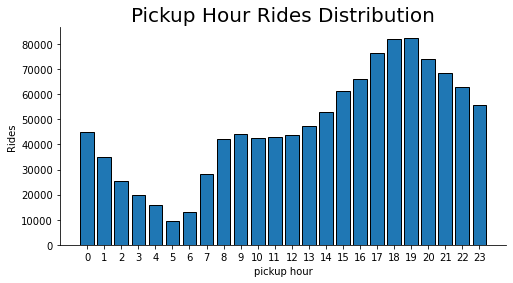

In [21]:
# fetching pickup counts grouped by hour
pick_rides_count = df_new.groupby('pickup_hour').count()['VendorID']


fig, ax = plt.subplots(figsize=(8,4))
plt.bar(x=pick_rides_count.index,height=pick_rides_count.values,edgecolor = "black",linewidth=1)

bins=24

ax.set_title('Pickup Hour Rides Distribution',fontsize=20)
ax.set_xlabel('pickup hour')
ax.set_ylabel('Rides')
ax.set_xticks(range(bins))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.show()

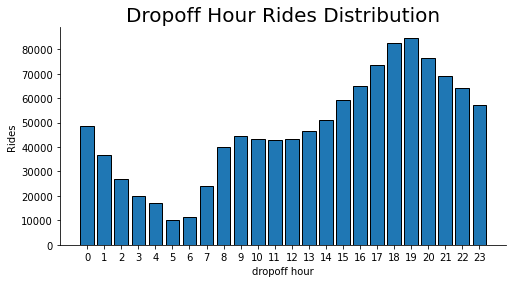

In [22]:
# fetching dropoff counts grouped by hour
drop_rides_count = df_new.groupby('dropoff_hour').count()['VendorID']

fig, ax = plt.subplots(figsize=(8,4))
plt.bar(x=drop_rides_count.index,height=drop_rides_count.values,edgecolor = "black",linewidth=1)

bins=24

ax.set_title('Dropoff Hour Rides Distribution',fontsize=20)
ax.set_xlabel('dropoff hour')
ax.set_ylabel('Rides')
ax.set_xticks(range(bins))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.show()
plt.show()

<div class="alert alert-block alert-success">
<strong>Insights</strong> - The pattern of pickup is same as the pattern of drop off. This makes sense as from trip distance histogram we can see that most of trips occured within 2 mile range. Also, we can see that most of the pickup and dropoff occurs between 6pm - 8pm whereas least happens early in the morning i.e. between 2am and 7am

In [23]:
# calculating mean of extra amount per hour
extra = df_new.groupby('dropoff_hour').mean()['extra']

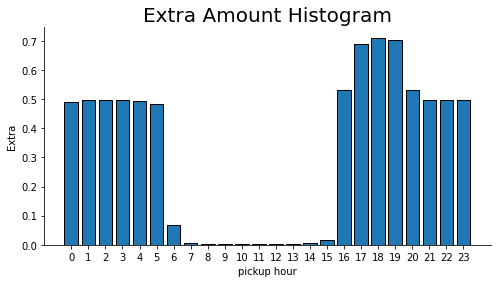

In [24]:
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x=extra.index,height=extra.values,edgecolor = "black",linewidth=1)

ax.set_xticks(range(24))


ax.set_xlabel('pickup hour')
ax.set_ylabel('Extra')
ax.set_title('Extra Amount Histogram',fontsize = 20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.show()

<div class="alert alert-block alert-success">
<strong>Insights</strong> - Extra amount is neglegible between 7am to 3pm.

# Model

#### Answer 4

<div class="alert alert-block alert-info">
    
- Since tip for cash payment is not recorded therefore, we can build the model using card type data only



In [25]:
# fetching data for which payment_type is not equal to 2 as payment_type 2 denotes cash

df_tip = df_new[df_new['payment_type']!=2]
X = df_tip.drop(['tip_amount'],axis=1)
y = df_tip['tip_amount']

In [26]:
# Performing train, test and validation split

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1)

X_train =  X_train.reset_index(drop=True)
X_valid =  X_valid.reset_index(drop=True)
X_test =  X_test.reset_index(drop=True)
X_train_full =  X_train_full.reset_index(drop=True)

y_train =  y_train.reset_index(drop=True)
y_valid =  y_valid.reset_index(drop=True)
y_test =  y_test.reset_index(drop=True)
y_train_full =  y_train_full.reset_index(drop=True)

<div class="alert alert-block alert-info">

- Predicting the exact tip amount is a regression problem. Therefore applying RandomForestRegressor

In [27]:
#Label encoding the categorical features that are of type string

def enc_cat_feat(train,test=None):
    cat_cols = list(train.dtypes[train.dtypes == object].index)

    for col in cat_cols:
        le_col = LabelEncoder().fit(train[col])
        train[col] = le_col.transform(train[col])
        if test is not None:
            test[col] = le_col.transform(test[col])


enc_cat_feat(X_train,X_valid)

<div class="alert alert-block alert-info">
From above analysis we saw that fare_amount, mta_tax, improvement_surcharge, total_amount, trip_type, and dropoff_hour has high correlation with other features. Also lpep_pickup_datetime and lpep_dropoff_datetime, will have high correlation with pickup_hour and dropoff_hour respectively they were extracted from the former. Therefore dropping the highly correlated features from the dataset.

In [28]:
drop_cols = ['fare_amount','mta_tax','improvement_surcharge','total_amount','lpep_pickup_datetime',
             'lpep_dropoff_datetime','dropoff_hour','trip_type']

In [29]:
X_train = X_train.drop(drop_cols, axis=1)
X_valid = X_valid.drop(drop_cols, axis=1)


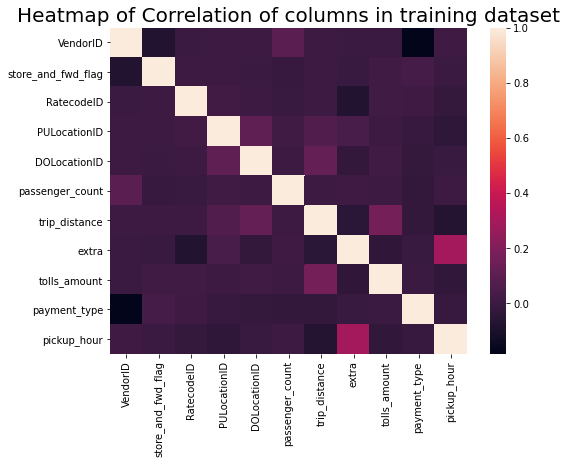

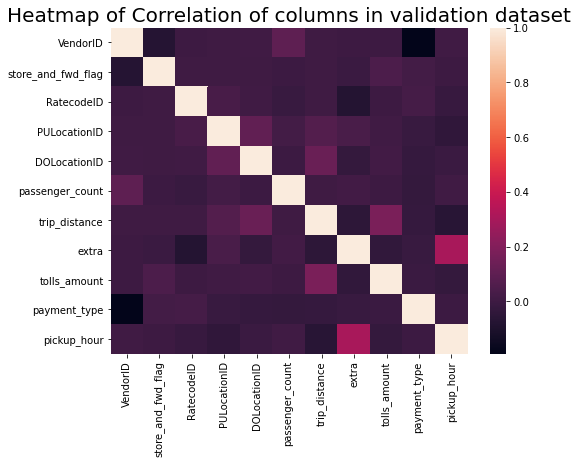

In [30]:
cor_heatmap(X_train,title = 'Heatmap of Correlation of columns in training dataset')
cor_heatmap(X_valid,title = 'Heatmap of Correlation of columns in validation dataset')

<div class="alert alert-block alert-info">
Now we can see that extra is also having a moderate correlation with the pickup_hour. Therefore dropping extra from our dataset

In [31]:
X_train = X_train.drop(['extra'], axis=1)
X_valid = X_valid.drop(['extra'], axis=1)


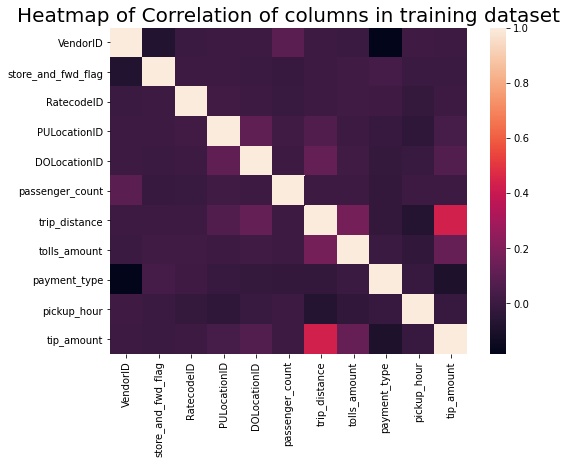

In [32]:
# finding correlation between features and target variable
cor_heatmap(pd.concat([X_train,y_train],axis=1),title = 'Heatmap of Correlation of columns in training dataset')

<div class="alert alert-block alert-info">
We can also see that out of all the features trip_distance and tolls_amount shows moderate correlation with the tip_amount. We can now start building our model

In [33]:
#Hyperparameter tuning

def get_random_values_hyperparameters():
    min_samples_leaf = np.random.randint(low=2, high=5, size=1)[0]
    max_depth = np.random.randint(low=6, high=40, size=1)[0]
    return min_samples_leaf,max_depth

for i in range(10):
    h1, h2 = get_random_values_hyperparameters()
    rf = RandomForestRegressor(n_jobs = -1, n_estimators=40, min_samples_leaf=h1,
                                 max_depth=h2, verbose=1)
    rf.fit(X_train, y_train)

    y_train_pred = rf.predict(X_train)
    
    y_valid_pred = rf.predict(X_valid)
    print("min_samples_leaf %d, max_depth %d" % (h1, h2))
    print("   train r2 score %.2f, val r2 score %.2f" % (r2_score(y_train, y_train_pred),
          r2_score(y_valid, y_valid_pred)))
    print("   train MAE %.2f, val MAE %.2f" % (mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_valid, y_valid_pred)))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 3, max_depth 31
   train r2 score 0.55, val r2 score 0.25
   train MAE 0.62, val MAE 0.89


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 3, max_depth 17
   train r2 score 0.41, val r2 score 0.26
   train MAE 0.81, val MAE 0.87


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 4, max_depth 13
   train r2 score 0.30, val r2 score 0.27
   train MAE 0.85, val MAE 0.87


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 2, max_depth 15
   train r2 score 0.39, val r2 score 0.25
   train MAE 0.83, val MAE 0.87


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 3, max_depth 15
   train r2 score 0.36, val r2 score 0.27
   train MAE 0.83, val MAE 0.87


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished


min_samples_leaf 2, max_depth 31
   train r2 score 0.65, val r2 score 0.22
   train MAE 0.55, val MAE 0.91


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 3, max_depth 19
   train r2 score 0.45, val r2 score 0.26
   train MAE 0.77, val MAE 0.87


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 3, max_depth 36
   train r2 score 0.55, val r2 score 0.25
   train MAE 0.62, val MAE 0.90


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 2, max_depth 9
   train r2 score 0.24, val r2 score 0.26
   train MAE 0.87, val MAE 0.88


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


min_samples_leaf 2, max_depth 10
   train r2 score 0.26, val r2 score 0.25
   train MAE 0.87, val MAE 0.88


[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished


<div class="alert alert-block alert-success">
Best result (train MAE 0.81, val MAE 0.87) is for hyperparameters - min_samples_leaf 3 and max_depth 17

#### Training on X_train_full data
<div class="alert alert-block alert-success">
Now, after obtaining the best hyperparameters, we combine the test and validation data and train the model on entire dataset. In this new training we can keep even higher number of trees

In [35]:
enc_cat_feat(X_train_full,X_test)

X_train_full = X_train_full.drop(drop_cols, axis=1)
X_test = X_test.drop(drop_cols, axis=1)


In [36]:
h1,h2 = 3,10

rf = RandomForestRegressor(n_jobs = -1, n_estimators=50, min_samples_leaf=h1,
                                  max_depth=h2, verbose=1)
rf.fit(X_train_full, y_train_full)

y_train_pred = rf.predict(X_train_full)

y_test_pred = rf.predict(X_test)
print("min_samples_leaf %d, max_depth %d" % (h1, h2))
print("   train r2 score %.2f, test r2 score %.2f" % (r2_score(y_train_full, y_train_pred),
      r2_score(y_test, y_test_pred)))
print("   train MAE %.2f, test MAE %.2f" % (mean_absolute_error(y_train_full, y_train_pred),
    mean_absolute_error(y_test, y_test_pred)))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


min_samples_leaf 3, max_depth 10
   train r2 score 0.25, test r2 score 0.20
   train MAE 0.87, test MAE 0.88


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


#### Training on X_train_full data
<div class="alert alert-block alert-success">
The model trained on train and val data shows MAE of 0.87 on train and 0.88 on test data

# **Anomaly Detection**

### Answer 5


<div class="alert alert-block alert-info">
To find the anomaly Isolation Forest is used. Ideally before applying Isolation Forest we should have an idea about the amount of anomaly to expect. In this assumption of 1 percent anomaly in entire data was made

In [37]:
contamination = 0.01

merged_data = pd.concat([df_new.reset_index(drop=True),y.reset_index(drop=True)],axis=1)


<div class="alert alert-block alert-info">
Islolation Forest was applied on dataset df_new as it contains all the records. However, we need to drop the correlated columns

In [38]:
enc_cat_feat(df_new)
df_new = df_new.drop(drop_cols, axis=1)

islf = IsolationForest(contamination=contamination,n_estimators=500).fit(df_new)

anomaly = islf.predict(df_new)

#Anomaly Data
df_new.iloc[np.where(anomaly==-1)]

,VendorID,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,extra,tip_amount,tolls_amount,payment_type,pickup_hour
145,2,0,1,223,263,5,5.87,0.5,2.00,0.00,1,0
190,2,0,1,255,49,6,2.76,0.5,2.46,0.00,1,0
243,2,0,1,255,107,5,5.03,0.5,3.76,0.00,1,0
256,2,0,5,259,69,1,6.60,0.0,0.00,0.00,2,0
335,2,0,5,174,182,1,6.62,0.0,0.00,0.00,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1224002,1,0,1,7,243,1,7.50,0.5,7.30,5.54,1,23
1224060,1,0,1,255,181,2,6.30,0.5,4.15,0.00,1,23
1224094,1,0,5,210,39,1,6.90,0.0,0.00,0.00,2,23
1224124,1,0,1,33,256,4,3.80,0.5,3.25,0.00,1,23
